<i>STATUS: Draft<i>

In [1]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle, Circle, ConnectionPatch
from IPython.display import Image
import sys
import pandas as pd
import HTM_Code as hc
import colorsys
import time as timer

We are now starting a get a handle on the basics, and have made quite a bit of progress: we  know how to create SDRS; we have mechanimsms to compare SDRs and we have started to think about fault tolerence and noise; we have some rudimentary strategies to deal with fault tolerance and add noise to SDRs. We also have an Encoder which allows us to take an multiple inputs, and find a way to keep their semantic meaning (at least in a numerical sense). We also have developed the idea of of multiple Encoder that allows to join a number of Encoders together so we can more complex imports. And finally, we have some nice visualisation functions.

Our slowly growing code base, <code>HTM_Code.py</code> is probably due for a refactor soon, but for the purpose of developing our understanding, its fine for now. 

<h4>Spatial Pooler</h4>

The next important component we need to deal with in HTM is the Spatial Pooler (SP). From the literature we can get an initial definition for this: 

<div style="padding-left: 150px; padding-right: 150px; ">

<i>The [Spatial Pooler] models how neurons learn feedforward connections and form efficient representations of the input. It converts arbitrary binary input patterns into sparse distributed representations (SDRs) using a combination of competitive Hebbian learnig rules and homeostatic exciteability control</i>
    <br/>
    <br/>
    -- Spatial Pooling, Biological & Machine Intelligence
</div>

There is quite a bit in that definition. But don't worry, by the time we work through the next couple of notebooks, it will make a lot more sense. 

In terms of resources for learning about the Spatial Pooler, the best place is to start with relevant HTM School episodes, which are quite intuitive but I did find them I needed to watch them a few times to really get a handle on things. There are also a couple of key papers to be aware of (but note they are a little more dense). In any case, we will draw from all these resources as needed. 

* HTM Spatial Pooler - Neocortical Algorthm for Online Sparse Distributed Encoding (Yuwei Cui, Subutai Ahmad and Jeff Hawkins)<br/>
<i>https://www.frontiersin.org/articles/10.3389/fncom.2017.00111/full#:~:text=The%20HTM%20Spatial%20Pooler%E2%80%94A%20Neocortical%20Algorithm%20for%20Online%20Sparse%20Distributed%20Coding,-Yuwei%20Cui%2C%20Subutai&text=Hierarchical%20temporal%20memory%20(HTM)%20provides,computational%20principles%20of%20the%20neocortex.&text=We%20then%20demonstrate%20the%20value,end%20real%2Dworld%20HTM%20system. </i>

* Biological and Machine Intelligence (BAMI) chapter on Spatial Pooling (Numenta)<br/>
<i>https://numenta.com/resources/biological-and-machine-intelligence/spatial-pooling-algorithm/</i>

In [2]:
ep7 = '<iframe style="background:#99ddff; color:black; padding: 10px" width="400" height="315" src="https://www.youtube.com/embed/R5UoFNtv5AU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
ep8 = '<iframe  style="background:#99ddff; color:black; padding: 10px" width="400" height="315" src="https://www.youtube.com/embed/rHvjykCIrZM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
table = '<table style="width:100%"><tr><td>' + ep7 + '</td><td>' + ep8 + '</td></tr>'
HTML(table)

,


<b>Episodes 7 & 8 </b>

A couple of caveats just around how I have approached this: firstly I found it easier to detail with episodes 7 and 8 at the same time as when you any kind some kind of implementation (even the simple one we are doing), you need to go between them a little. Secondly, there is a great working example which from measurements of the power consumption in a gym over different dates and times. I will spend some more time in this notebook just getting to an understanding of the Spatial Pooler, and then in the notebook we will introduce the gym data as our working example

Let's provide some biological context. We have looked SDRs but it hasn't been overly clear how they relate to the neurons. There is a really nice analagy Matt mentions at the beginning of Episode 7 relating input. 


So far we have looked at individual cells in the neocortex, but we haven't said anything further in terms of the overall structure. There is additional structure, and the cells in the neocortex are structured into vertical columns (source: montcastle). You can think of individual column as containing around 100-150 cells. Note that each column has an associated dendritic segment which allows the connection to the input space. It has potential synapses representing a random subset of input bits. You can think of this columns as reciever of inputs. 

And in this context, what exactly do mean by input. as an observer that recieves information and decides to fire, an2 ways to look, from pramidal neoron, observe all sdrs deciding when it fires....and also plays a part in part of SDRS - by fiuring and turns bit on when it recognises 

spatial pooling.....

biology of neocorext

heiracty of regions....gets input from sensory etc. 

input space is figure optics, whether neuron is on or off

cortex needs to normalise input in order to learn....

size of input space variable - look at it in different ways

SP - gets input vector.....translates into output vector with a sparse number of active bits

Output vector of SP represents minicolumns...which are col of pyramidal neorons in the neorcrotex....important 

2 goals of spatial pooling...
- maintain fixed sparsity - as it sees input SP will maintain sparsity
- maintain overlap properties  

...need to recognise overlaps in input etc....

spatial pooler is learning algorithm.... today we talk about input space


SP input space - is multi encoder from gym example
- each data points represented in input space

Aim one - iterate through all dat and encode...

This data set has certain signatures......could be random input or not....semantic meaning remains...

Step 1 - feed data into multiencoder   

Step 2.....inititalise
LEFT - SOME INPUT SPACE
RIGHT - SP COLUMNS
so each SP columsn is connected to subset of input spacte

Every column has potential pool that it might be connected to - randomly potentially connected - here to 85%, we can reset..... SP has initial settings
each of the 85% of potential connections has permanence connected...heat map shows connections - which has no connection in red, then heat map connections

white cells - no connection to
all others have a permance value that may be below threshold

each col has relationship to every cel in input space
- some will never connect
- others will have different levels of connectivity
- blue circle means there is a connection from columm to cell in input space, and 
- blue circles are an outomce of of if permance threshold is met, they can have a connection - so all squares have either no, connectino, connection below threshold, or connection above threshold, and those above are blue dots apppear

- can change to .4 - map to only 40%, and then blue dots appear only above connection threshold of that 40% - 
- POTENTIAL POOL - all possible connections set to 85%, then 40%
- CONNECTINO THRESHOLD - set heatmap, and blue dots - randominly initialise heatmap settings I think
- in setting up  permance valus randomly, this happens around the threshold.....so number of connections still kind of works - set up  as normal distribution around connection threshold

Now.....we can look at input.. we get random SDR coming in....

Eeach column mapped to input space

We can consider if col mapped to input space, some overlapping with data, some don't 

Idea is that cols learn, through reinforcement (see input on connection) or don't see anything

Also - idea of input / cell overlap

use overlap to "activate cols" - 


So this tells us we need 4 numerical encoders: 1 for consumption, one for time of day, 1 for weekend. We need to think about paramaters




<div style="padding-left: 150px; padding-right: 150px; ">

<i>First, the values are chosen to be in a small range around connectedPerm, the minimum permanence value at which a synapse is considered “connected”. This enables potential synapses to become connected (or disconnected) after a small number of training iterations. Second, each column has a natural center over the input region, and the permanence values have a bias towards this center, so that they have higher values near the center.</i>
    <br/>
    <br/>
    -- Spatial Pooling, Biological & Machine Intelligence
</div>

We are going to create a vew different versions of our Spatial Pooler, and move foward slowly to become more sophisticated. Here is a first version with a couple of features: 

In [3]:
class SpatialPoolerV1:
    def __init__(self):
        self.input_space_size = 400
        self.potential_pool = .85
        self.connection_threshold = 0.1
        self.connection_threshold_sd = 0.01
        self.columns = {}
        self.connected_columns = None
        self.non_connected_columns = None
        self.connected_columns_permanence_values = None
        self.columns_initialised = False
        
    def get_summary(self):
        print("----------------- SUMMARY -------------------------")
        print("|L1| Capacity of mini-columns in spatial pooler:", self.input_space_size)
        print("|L2| Potential pool of each minicolumn:", self.potential_pool * 100, "%")
        print("|L2| Connection threshold:", self.connection_threshold)
        print("|L2| Connection threshold standard deviation:", self.connection_threshold_sd)
        print("|L4| Columns initialised:", self.columns_initialised)
        
        
    def initialise_columns_to_input_space(self):
        potential_pool_size = int(self.potential_pool * self.input_space_size)

        for i in range(self.input_space_size):
           

            potential_connections = hc.create_randomised_sdr(self.input_space_size, potential_pool_size)
            non_connected_columns = [x for x in range(0, self.input_space_size) if x not in potential_connections]
            potential_connections_permanence_values = np.random.normal(self.connection_threshold, 0.01, potential_pool_size)
            connected_columns = []
            for j in range(0, len(potential_connections)):
                if potential_connections_permanence_values[j] > 0.1:
                    connected_columns.append(potential_connections[j])
                    
        
            self.columns[i] = {'potential_connections': potential_connections,
                              'non_connected_columns': non_connected_columns,
                               'potential_connections_permanence_values': potential_connections_permanence_values,
                               'connected_columns': connected_columns
                              }
        print("Each of the", self.input_space_size, "mini-columns in this Spatial Pooler has now each randomonly connected to", self.potential_pool, 
              "of bits in the input space. The connection strength is approximately between", min(self.columns[0]['potential_connections_permanence_values']),
             "and", max(self.columns[0]['potential_connections_permanence_values']), "with a mean of", self.connection_threshold, 
             "There are" , len(self.columns[0]['connected_columns']), "connected")

            

Now let's create our first spatial pooler: 

In [4]:
bit_space_size_choice = 400
number_of_bits_used_to_encode_value_choice = 8

s1 = SpatialPoolerV1()
s1.get_summary()


----------------- SUMMARY -------------------------
|L1| Capacity of mini-columns in spatial pooler: 400
|L2| Potential pool of each minicolumn: 85.0 %
|L2| Connection threshold: 0.1
|L2| Connection threshold standard deviation: 0.01
|L4| Columns initialised: False


What is this telling us. We set the number of columns to 400, each of these can connect to a potential pool of .85% of 400. We will also set a connection threshold. Let's now initialise the columns

In [5]:
s1.initialise_columns_to_input_space()

Each of the 400 mini-columns in this Spatial Pooler has now each randomonly connected to 0.85 of bits in the input space. The connection strength is approximately between 0.0698314158583049 and 0.12556214587309977 with a mean of 0.1 There are 175 connected


Nothing of much interest has happened so far, but its worth visualising it to get a better intuition for what is happening here. For this, I am going to use the visualisation functions I have already set up, just adding a couple small things to visualise the the differet thresholds as a color, and a functino to offset coordinate to make it easy to draw things circles and lines between graphs. 

In [6]:
def compute_color(c, min_in_range, max_in_range):
    ival = np.interp(c,[min_in_range,max_in_range],[0,1])
    rgb = colorsys.hsv_to_rgb(0, ival,  1)
    return(rgb)

def offset_coords_for_visualisation(c, offset_amount):
    coords = np.array(c)
    coords = coords + offset_amount
    return(tuple(coords))

For our 400 mini-columns that are now initialised, let's just choose one at random and see what is connected to:

In [7]:
mini_column_choice = np.random.randint(0, s1.input_space_size)
print(mini_column_choice)

18


And now visualise:

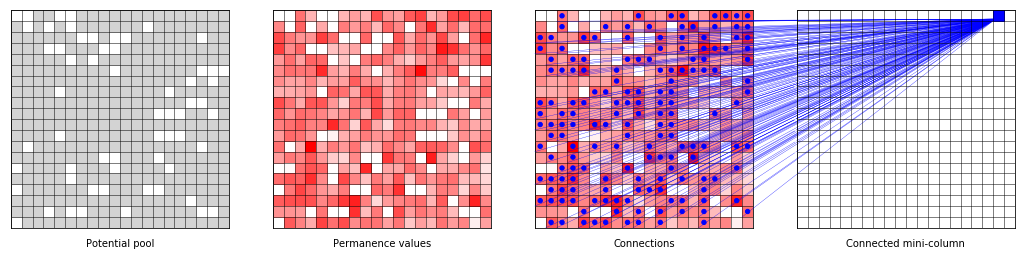

In [8]:
column_of_interest = s1.columns[mini_column_choice ]
min_permanence_value = min(s1.columns[mini_column_choice ]['potential_connections_permanence_values'])
max_permanence_value = max(s1.columns[mini_column_choice ]['potential_connections_permanence_values'])
column_coords = hc.convert_sdr_to_tuple_for_visualisation([mini_column_choice ], bit_space_size_choice)[0]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = hc.create_axis_for_sdr(ax1, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Potential pool")
ax2 = hc.create_axis_for_sdr(ax2, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Permanence values")
ax3 = hc.create_axis_for_sdr(ax3, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Connections")
ax4 = hc.create_axis_for_sdr(ax4, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Connected mini-column")

coords1 = hc.convert_sdr_to_tuple_for_visualisation(column_of_interest['potential_connections'], bit_space_size_choice)
coords2 = hc.convert_sdr_to_tuple_for_visualisation(column_of_interest['connected_columns'], bit_space_size_choice)

p1 = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color = "lightgray")) for i in range(len(coords1))]
p1 = [ax2.add_patch(Rectangle(coords1[i], 1, 1, color = compute_color(column_of_interest['potential_connections_permanence_values'][i], min_permanence_value, max_permanence_value))) for i in range(len(coords1))]
p1 = [ax3.add_patch(Rectangle(coords1[i], 1, 1, color = compute_color(column_of_interest['potential_connections_permanence_values'][i], min_permanence_value, max_permanence_value))) for i in range(len(coords1))]
p3 = [ax3.add_patch(Circle(offset_coords_for_visualisation(coords2[i], .5), .2, color = "blue")) for i in range(len(coords2))]


p3 = ax4.add_patch(Rectangle(column_coords, 1, 1, color = "blue"))
p3 = [ax4.add_artist(ConnectionPatch(xyA=offset_coords_for_visualisation(column_coords, .2), xyB=coords2[i], coordsA="data", coordsB="data",
                       axesA=ax4, axesB=ax3, color="blue", linewidth = 0.3)) for i in range(len(coords2))]

plt.savefig("./Images/spatial_pooler_columns.svg", dpi = 300)

<div style="background:#99ddff; color:black; padding: 10px">
<b>Add to these notes:</b>
    <br/>
<div>I love matplotlib, but sometimes rendering really high quality images directly is difficulty NOte that can also write image svg files. Just an aside to say this quite I created one with the last line of code
    </div>
    <img src = "Images/spatial_pooler_columns.svg"></img>
</div>


So far we have set this up, so its mini-column is connected a potential pool. Another way to visualise this is, for any bit in the input space, which columsn is it connected to?

Now let's look at some input. Before I do this however, I am going to create an SDR class as well. The reason for this, is that SDR is really not just the following function:

In [9]:
np.array(hc.create_randomised_sdr(400, 20))

array([388, 137, 270,  14, 147,  33, 305,  58,  63,  68, 201,  76, 338,
        83,  86, 350, 356, 357, 108, 381])

But an SDR is not just 20 random inputs, it is something a little more nuanced. For instnace, SDR knows about its toal input space, and its sparsity, so its like an array with certain attributes. This is a small thing, but as we go forward it will help us

Let's just create an object to manage an SDR

In [10]:
class SDR:
    def __init__(self, input_space_size, number_of_active_bits, label):
        self.input_space_size = input_space_size
        self.number_of_active_bits= number_of_active_bits
        self.active_bits = hc.create_randomised_sdr(self.input_space_size, self.number_of_active_bits)
        self.label = label
    def get_summary(self):
        print("----------------- SUMMARY -------------------------")
        print("|L1| Label:", self.label)
        print("|L1| Input space size of SDR:", self.input_space_size)
        print("|L2| Number of active bits in SDR:", self.number_of_active_bits)
        print("|L3| Percentage of active bits:", (self.number_of_active_bits / self.input_space_size) * 100, "%")
        print("|L3| Active bits:", self.active_bits)

In [11]:
sd1 = SDR(400, 20, "some_label")
sd1.get_summary()

----------------- SUMMARY -------------------------
|L1| Label: some_label
|L1| Input space size of SDR: 400
|L2| Number of active bits in SDR: 20
|L3| Percentage of active bits: 5.0 %
|L3| Active bits: [388, 15, 274, 20, 151, 153, 154, 29, 200, 332, 207, 208, 344, 106, 236, 109, 370, 115, 122, 381]


Now back to the Spatial Pooler. Let's create a version 2 and this version will allow us to pass an input in and see which columns that it is connected to. We will also add a few more features to it to bring out other properties:

In [12]:
input_space_size = 1024
bit_space_size_choice = 1024
active_bits_in_inputs = 32

class SpatialPoolerV2:
    def __init__(self):
        self.input_space_size = 1024
        self.potential_pool = .45
        self.connection_threshold = 0.1
        self.connection_threshold_sd = 0.01
        self.columns = {}
        self.connected_columns = None
        self.non_connected_columns = None
        self.connected_columns_permanence_values = None
        self.columns_initialised = False
        self.inputs  = []
        self.input_active_bits = None
        self.connections_of_bits_in_input_space_to_columns = None
        self.inputs_connected_to_columns = []
        
    def add_inputs(self, inputs, multiple = True):
        self.inputs = inputs
        
        
    def compare_inputs_to_connected_columns(self, log=True):
        for i in range(len(self.inputs)):
            for key, value in self.columns.items():
                temp_dict = {}
                overlap = list(set(value['connected_columns']).intersection(self.inputs[i].active_bits))
                temp_dict[self.inputs[i].label] = [{"column": key},{"overlap_score": len(overlap)}, {"overlap_bits": overlap}]
                self.inputs_connected_to_columns.append(temp_dict)

    def get_summary(self):
        print("----------------- SUMMARY -------------------------")
        print("|L1| Capacity of columns in spatial pooler:", self.input_space_size)
        print("|L2| Potential pool of each column:", self.potential_pool * 100, "%")
        print("|L2| Connection threshold:", self.connection_threshold)
        print("|L2| Connection threshold standard deviation:", self.connection_threshold_sd)
        print("|L4| Columns initialised:", self.columns_initialised)
        print("|L5| Current number of inputs:", len(self.inputs))
        
    
        
    def initialise_columns_to_input_space(self):
        start_time = timer.perf_counter()
        potential_pool_size = int(self.potential_pool * self.input_space_size)

        for i in range(self.input_space_size):
        
            potential_connections = hc.create_randomised_sdr(self.input_space_size, potential_pool_size)
            non_connected_columns = [x for x in range(0, self.input_space_size) if x not in potential_connections]
            potential_connections_permanence_values = np.random.normal(self.connection_threshold, 0.01, potential_pool_size)
            connected_columns = []
            for j in range(0, len(potential_connections)):
                if potential_connections_permanence_values[j] > 0.1:
                    connected_columns.append(potential_connections[j])
                    
            self.columns[i] = {'potential_connections': potential_connections,
                              'non_connected_columns': non_connected_columns,
                               'potential_connections_permanence_values': potential_connections_permanence_values,
                               'connected_columns': connected_columns
                              }
            self.columns_initialised = True
            end_time = timer.perf_counter()
        print("-------------------- SUMMARY ---------------------------------")
        print("|L1| Based on initital paramaters, each of the", self.input_space_size, "columns in this Spatial Pooler has a potential connection to", self.potential_pool, "of bits in the input space")
        print("|L1| The values of all potential connection strength are normally distributed between approximately", np.round(min(self.columns[0]['potential_connections_permanence_values']), 3),
             "and", np.round(max(self.columns[0]['potential_connections_permanence_values']),3))
        print("|L1| Based on the connection threshold set at", self.connection_threshold,",", len(self.columns[0]['connected_columns']), "columns will now be connected to the input space")
        print("|L1| Time taken to initialise:", end_time - start_time, "seconds.")

             
        
    def compare_input_space_bits_to_columns(self):
        d = []
        for key, value in self.columns.items():
            for i in value['connected_columns']:
                d.append([i, key])
        d.sort()
        e = {}
        f = []
        d.append([-1, -1])
        for j in range(1, len(d) - 1):
            f.append(d[j][1])
            if d[j][0] != d[j + 1][0]:
                e[d[j][0]] = f
                f = []
        self.connections_of_bits_in_input_space_to_columns = e
            

# s2 = SpatialPoolerV2()
# s2.get_summary()
# s2.initialise_columns_to_input_space()
# random_inputs = [SDR(input_space_size,active_bits_in_inputs, "input_" + str(i)) for i in range(0,4)]
# random_inputs[0].get_summary()
# s2.add_inputs(random_inputs)
# s2.get_summary()
# s2.compare_input_space_bits_to_columns()
# s2.compare_inputs_to_connected_columns()

Let's try it out with another example. This time we will go up to an input space of 1024. We are start finding some performance issues now, and in the next version we will need reconsider a more vectorised style implementation, but in the interests of keeping things as inutitive as possible. We will start tracking the time involved however:

In [13]:
s2 = SpatialPoolerV2()
s2.get_summary()

----------------- SUMMARY -------------------------
|L1| Capacity of columns in spatial pooler: 1024
|L2| Potential pool of each column: 45.0 %
|L2| Connection threshold: 0.1
|L2| Connection threshold standard deviation: 0.01
|L4| Columns initialised: False
|L5| Current number of inputs: 0


So we have initialised Spatial pooler, with a larger inputs space. Let's now initialise those columns

In [14]:
s2.initialise_columns_to_input_space()

-------------------- SUMMARY ---------------------------------
|L1| Based on initital paramaters, each of the 1024 columns in this Spatial Pooler has a potential connection to 0.45 of bits in the input space
|L1| The values of all potential connection strength are normally distributed between approximately 0.067 and 0.126
|L1| Based on the connection threshold set at 0.1 , 226 columns will now be connected to the input space
|L1| Time taken to initialise: 6.186457200004952 seconds.


Before looking at how our inputs overlap to the columns, let's take a moment to compare the overlap of any bit in our input space to the columns its connected to. 

In [15]:
s2.compare_input_space_bits_to_columns()

So now let's look at some visualisations. The first thing to consider is just to have alook at each input space, and see what what columns it is connected to. When we created <code>compare_input_space_bits_to_columns()</code> which is a bit of a hacky function, but we won't really use it beyond the next visualisation. To this, let's choose 2 inputs spaces at random and then have a look at which columns they are connected to: 

In [16]:
random_bits_in_inputs_space = np.random.randint(0, 1024, 2)
random_bits_in_inputs_space

array([351, 804])

Our function above updated the variable <code>self.inputs_connected_to_columns</code> in our Spatial Pooler. So now its easy to us to get these values (<code>s2.inputs_connected_to_columns[290]</code> will tell us what columns the inputs space at 290 is connected to)

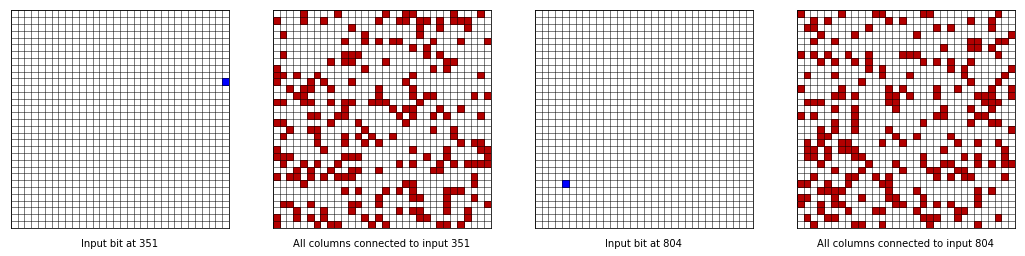

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = hc.create_axis_for_sdr(ax1, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, 
                             number_of_bits_used_to_encode_value_choice, "Input bit at " + str(random_bits_in_inputs_space[0]))
ax2 = hc.create_axis_for_sdr(ax2, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, 
                             number_of_bits_used_to_encode_value_choice, "All columns connected to input " + str(random_bits_in_inputs_space[0]))
ax3 = hc.create_axis_for_sdr(ax3, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, 
                             number_of_bits_used_to_encode_value_choice, "Input bit at " + str(random_bits_in_inputs_space[1]))
ax4 = hc.create_axis_for_sdr(ax4, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, 
                             number_of_bits_used_to_encode_value_choice, "All columns connected to input " + str(random_bits_in_inputs_space[1]))

coords1 = hc.convert_sdr_to_tuple_for_visualisation([random_bits_in_inputs_space[0]], bit_space_size_choice)
coords2 = hc.convert_sdr_to_tuple_for_visualisation([random_bits_in_inputs_space[1]], bit_space_size_choice)
coords3 = hc.convert_sdr_to_tuple_for_visualisation(s2.connections_of_bits_in_input_space_to_columns[random_bits_in_inputs_space[0]], bit_space_size_choice)
coords4 = hc.convert_sdr_to_tuple_for_visualisation(s2.connections_of_bits_in_input_space_to_columns[random_bits_in_inputs_space[1]], bit_space_size_choice)

p = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color = "blue")) for i in range(len(coords1))]
p = [ax3.add_patch(Rectangle(coords2[i], 1, 1, color = "blue")) for i in range(len(coords2))]
p = [ax2.add_patch(Rectangle(coords3[i], 1, 1, color = "#b30000")) for i in range(len(coords3))]
p = [ax4.add_patch(Rectangle(coords4[i], 1, 1, color = "#b30000")) for i in range(len(coords4))]


Its wotrth notin as well thatthe inputs onnections are normally distributed 

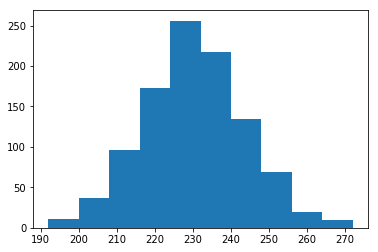

In [19]:
p = plt.hist([len(s2.connections_of_bits_in_input_space_to_columns[i]) for i in s2.connections_of_bits_in_input_space_to_columns])

Next, let's add some inputs. Eventually we probably don't want to store the inputs in our Spatial Pooler, we will need to figure out a better way to do this, and later we can look more closely at both the Nupic code base and htm.core. But for now, its fine. Let's create 4 random inputs, using our SDR class, and just to make sure it worked, we will the summary for the first one that we have created:  

In [20]:
random_inputs = [SDR(input_space_size,active_bits_in_inputs, "TimeStep_" + str(i)) for i in range(0,4)]
random_inputs[0].get_summary()

----------------- SUMMARY -------------------------
|L1| Label: TimeStep_0
|L1| Input space size of SDR: 1024
|L2| Number of active bits in SDR: 32
|L3| Percentage of active bits: 3.125 %
|L3| Active bits: [131, 519, 392, 265, 776, 784, 785, 402, 531, 276, 408, 27, 544, 802, 549, 172, 948, 703, 320, 709, 459, 462, 208, 81, 725, 863, 609, 483, 746, 495, 117, 380]


Now add them to our Spatial Pooler. We can rerun the summary which will tell us that they are in the Spatial Pooler 

In [21]:
s2.add_inputs(random_inputs)
s2.get_summary()

----------------- SUMMARY -------------------------
|L1| Capacity of columns in spatial pooler: 1024
|L2| Potential pool of each column: 45.0 %
|L2| Connection threshold: 0.1
|L2| Connection threshold standard deviation: 0.01
|L4| Columns initialised: True
|L5| Current number of inputs: 4


In [22]:
s2.compare_inputs_to_connected_columns()

This notebook is getting a bit long, so let's revisit the gym example in the next one